<a href="https://colab.research.google.com/github/DuanMingbai/PyTorch_Tutorials_cn/blob/main/Introduction%20to%20PyTorch/3_DATASETS%E5%92%8CDATALOADERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATASET和DATALOADER

处理数据样本的代码非常凌乱且不好维护。理想情况下我们希望我们的数据集代码和我们的模型代码解耦，已获得更好的可读性和模块化。PyTorch提供了两个数据方法```torch.utils.data.DataLoader```和```torch.utils.data.Dataset```，他们允许你用预处理好的数据集和你自己的数据集。```Dataset```存储了例子和它们对应的标签，并且DataLoader将Dataset打包成一个可以迭代的对象，让我们可以轻松访问样本。

PyTorch领域的库提供了一系列的预加载的数据集（例如FashionMNIST）是```torch.utils.data.Dataset```的子集，实现特定于特定数据的功能，它们可以被用作于你的模型的基准和原型。你可以从这里找到它们[图片数据](https://pytorch.org/vision/stable/datasets.html),[文本数据](https://pytorch.org/text/stable/datasets.html)和[音频数据]()

##加载数据集

这里有一个如何从TorchVision中加载Fashion-MNIST的例子。Fashion-MNIST 是 Zalando 文章图像的数据集，包含 60,000 个训练集和10,000测试集。每一个示例包含一个28×28的灰度和来自 10 个类别之一的相关标签。

我们用下列参数来初始化Fashion-MNIST


*   ```root```是数据/测试集存存储的路径，
*   ```train```指定是数据集还是测试集
*   ```download=True```如果第一条的```root```路径可用，就会从互联网下载数据集
*   ```transform```和```target_transform```指定特征和标签转换



In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



##迭代和可视化数据集

我们可以像索引list一样手动索引Dataset：```training_data[index]```。我们使用```matplotlib```在我们的训练集中可视化一些例子。

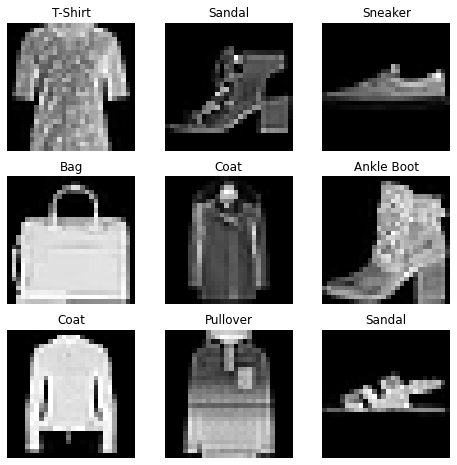

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

##创建你自己的数据集

一个自定义的数据集必须包含三个函数，```__init__```,```__len__```,和```__getitem__```。让我们看下面的代码；数据集中的图片被储存在```img_dir```这个路径下，它们的标签分别存储在 CSV 文件 annotations_file 中。

在下一节中，我们会分解每一个函数中都发生了什么。

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

####```__init__```

```__init__```在实例化数据集对象的时候会运行一次，我们初始化的目录包含图片，标注文件和两种东西的转换（在下一节中会更详细的介绍）


```lable.csv```文件看起来就像这样

```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```



In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

####```__len__```

```__len__```会返回我们数据集中的样本数。

In [ ]:
#例如
def __len__(self):
    return len(self.img_labels)

####```__getitem__```

```__getitem__```能够从数据集给定的指引```idx```加载并返回样本，基于索引，他可以识别图像在磁盘中的位置，通过```read_image```方法，用```self.img_labels```在csv文件中检索相应的标签，调用变换函数，返回一个元祖，这个元祖包含这个图片的tensor和对应的标签。

In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

##用DataLoader为你的训练准备数据

```Dataset```会检索我们数据集的特征并且每次标注一个样本，我们通常希望通过小批量传输样本，为了减少模型的过拟合，在每一次循环中（epoch）改组（说白了就是洗牌）数据，并且通过使用Python的```multiprocessing```方法去加速数据的检索。

\\
```DataLoader``` 是一个迭代器，它通过一个简单的 API 为我们抽象了这种复杂性。

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

##通过DataLoader迭代

我们已经用DataLoader加载了数据集，并且可以根据我们的需要去迭代。下面的代码每一次的迭代都会返回一批```train_features```和```train_labels```（分别包含```batch_size=64```个特征和标签），因为我们让```shuffle=True```，当我们迭代完所有的batch，数据将会进行一次洗牌（按照理解翻译的，标准翻译是改组）对数据加载顺序进行更细粒度的控制，

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


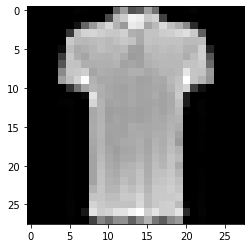

Label: 0


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

##阅读更多

[torch.utils.data API](https://pytorch.org/docs/stable/data.html)